# Car Evaluation
**Dataset: https://archive.ics.uci.edu/dataset/19/car+evaluation \
Task: We want to determine the acceptability of a car**

In [18]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from functools import partial


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.utils import shuffle
import random

## Step 1: Loading and Modifying Dataset 

In [19]:
Headers = ["Buying", "Maintenace", "Doors", "Persons","LugBoot","Safety","Class"]
df = pd.read_csv("car.data", names = Headers)

In [20]:
df = df.dropna()
nan_exists = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {nan_exists}")

Are there any NaN values in the DataFrame? False


In [21]:
df.head()

,Buying,Maintenace,Doors,Persons,LugBoot,Safety,Class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [22]:
class_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood':3}
df['Class'] = df['Class'].map(class_mapping)
df

,Buying,Maintenace,Doors,Persons,LugBoot,Safety,Class
0,vhigh,vhigh,2,2,small,low,0
1,vhigh,vhigh,2,2,small,med,0
2,vhigh,vhigh,2,2,small,high,0
3,vhigh,vhigh,2,2,med,low,0
4,vhigh,vhigh,2,2,med,med,0
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,2
1724,low,low,5more,more,med,high,3
1725,low,low,5more,more,big,low,0
1726,low,low,5more,more,big,med,2


In [23]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

In [24]:
#transforming to binary classification problem : 1 if acceptable or above, 0 OTW
df['Class'] = df['Class'].apply(lambda x: 1 if x > 0 else 0)

# Check the transformation
print(df['Class'].value_counts())

Class
0    1210
1     518
Name: count, dtype: int64


In [25]:
#Convert dataset to Numpy array for Classifiers 
df = df.values
print(df)

[[3 3 0 ... 2 1 0]
 [3 3 0 ... 2 2 0]
 [3 3 0 ... 2 0 0]
 ...
 [1 1 3 ... 0 1 0]
 [1 1 3 ... 0 2 1]
 [1 1 3 ... 0 0 1]]


## Step 2: Setting Up Classifiers

### KNN Classifier

In [26]:
def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(ylabel='$K$')
    plt.title(acc_desc + ' w.r.t $K$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [27]:
def knn(X_train_val, Y_train_val, X_test, Y_test):
    
    k_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':k_list}
    CGrid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    CGrid.fit(X_train_val, Y_train_val)
    
    draw_heatmap_knn(CGrid.cv_results_['mean_train_score'].reshape(6,1), 'KNN train accuracy', k_list)
    draw_heatmap_knn(CGrid.cv_results_['mean_test_score'].reshape(6,1), 'KNN val accuracy', k_list)
    
    BestK = CGrid.best_params_['n_neighbors']
    CTest = KNeighborsClassifier(n_neighbors=BestK)
    CTest.fit(X_train_val,Y_train_val)
    KnnAcc = CTest.score(X_test,Y_test)
    
    return BestK, KnnAcc

### Decision Tree Classifier

In [28]:
def draw_heatmap_dt(acc, acc_desc, D_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(ylabel='$D$')
    plt.title(acc_desc + ' w.r.t $D$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [29]:
def dt(X_train_val, Y_train_val, X_test, Y_test):
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    CGrid2 = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    CGrid2.fit(X_train_val, Y_train_val)
    
    draw_heatmap_dt(CGrid2.cv_results_['mean_train_score'].reshape(5,1), 'DT train accuracy', D_list)
    draw_heatmap_dt(CGrid2.cv_results_['mean_test_score'].reshape(5,1), 'DT val accuracy', D_list)
    
    BestD = CGrid2.best_params_['max_depth']
    CTest2 = DecisionTreeClassifier(max_depth=BestD, criterion="entropy")
    CTest2.fit(X_train_val, Y_train_val)
    DTAcc = CTest2.score(X_test,Y_test)
    
    return BestD, DTAcc

### Linear SVM Classifier

In [30]:
def draw_heatmap_svm(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [31]:
def svm_linear(X_train_val, Y_train_val, X_test, Y_test):
    C_list = np.array([10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1])
    parameters = {'C':C_list}
    CGrid3 = GridSearchCV(LinearSVC(), parameters, cv=5, return_train_score=True, n_jobs=-1)
    CGrid3.fit(X_train_val, Y_train_val)
    
    draw_heatmap_svm(CGrid3.cv_results_['mean_train_score'].reshape(6,1), 'Linear SVM train accuracy', C_list)
    draw_heatmap_svm(CGrid3.cv_results_['mean_test_score'].reshape(6,1), 'Linear SVM val accuracy', C_list)
    
    BestC = CGrid3.best_params_['C']
    CTest3 = LinearSVC(C=BestC)
    CTest3.fit(X_train_val, Y_train_val)
    SVCAcc = CTest3.score(X_test,Y_test)
    
    return BestC, SVCAcc

# Step 3: Perform Classification

## Partition: 80/20 -> 3 Trials 

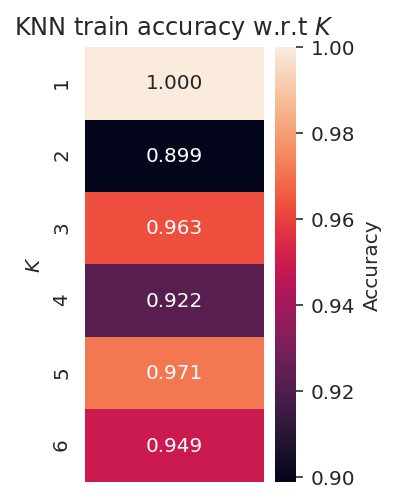

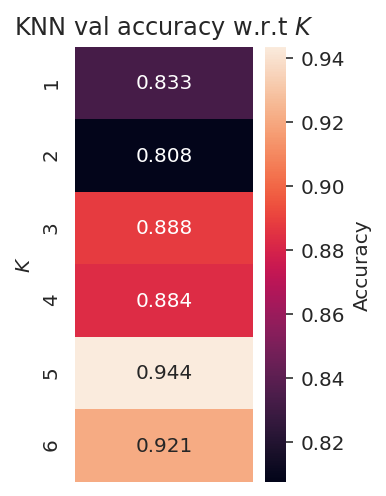

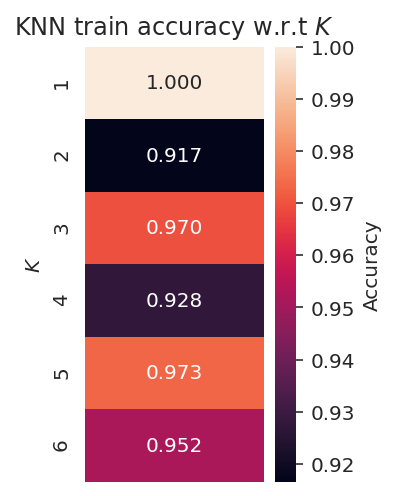

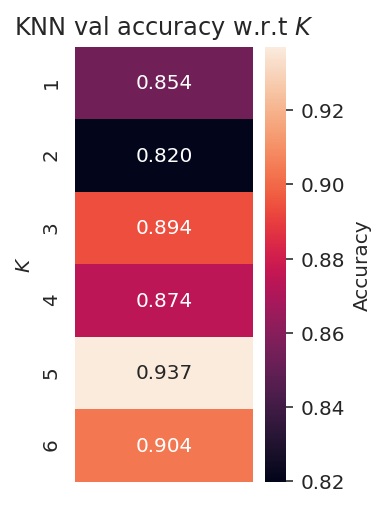

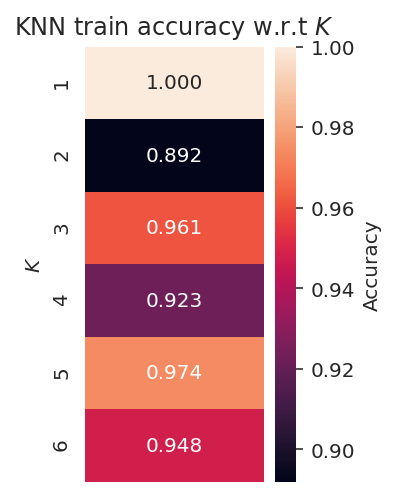

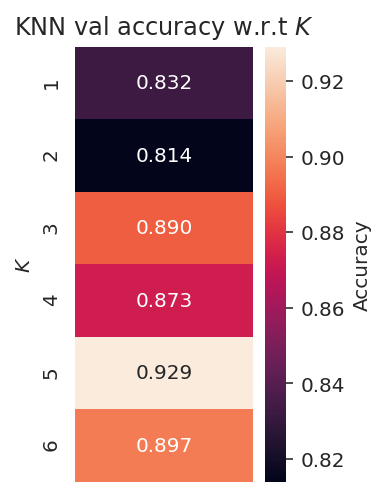

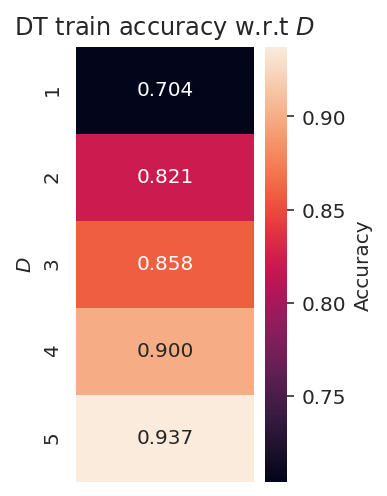

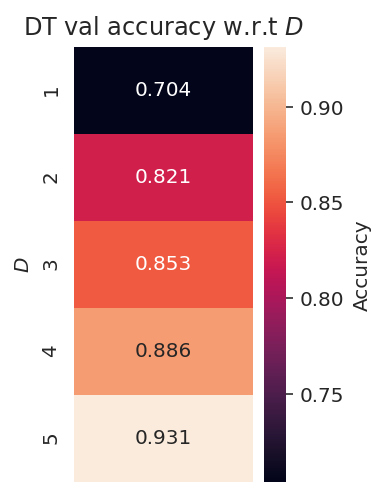

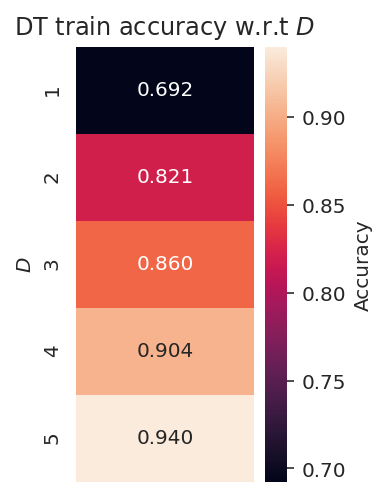

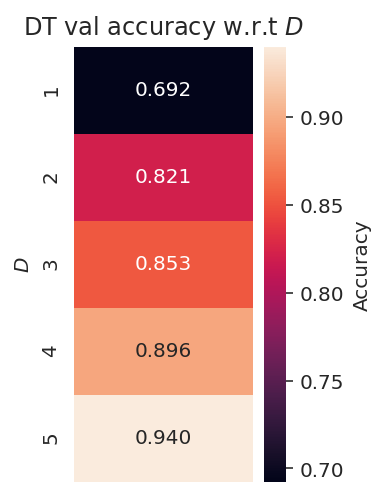

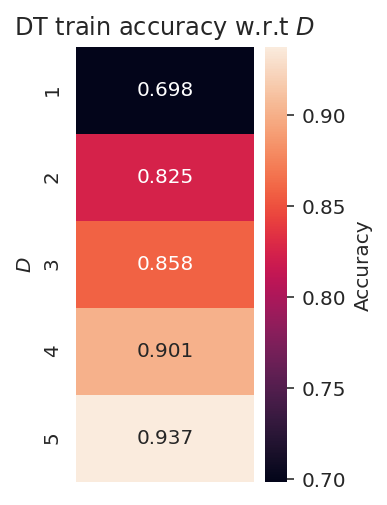

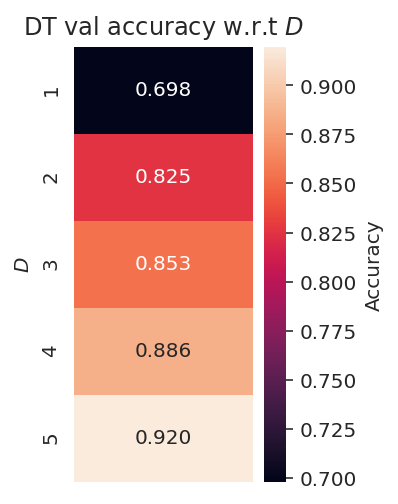

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

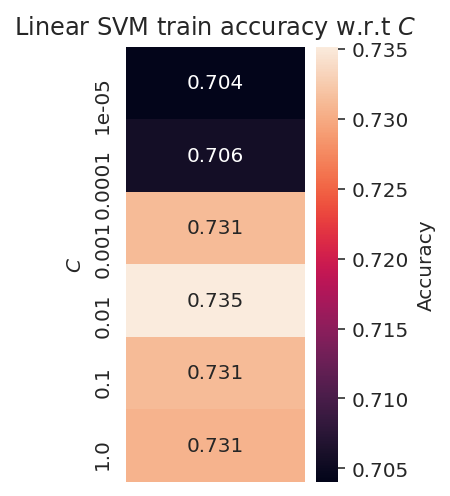

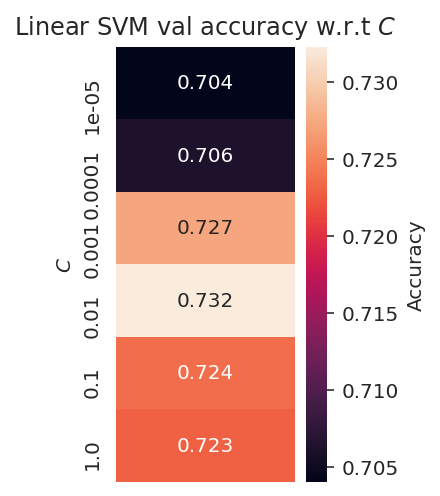

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

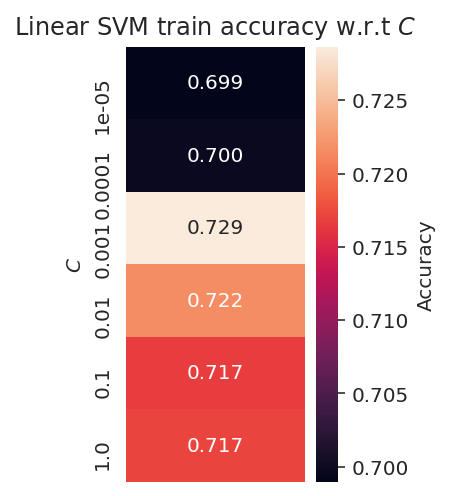

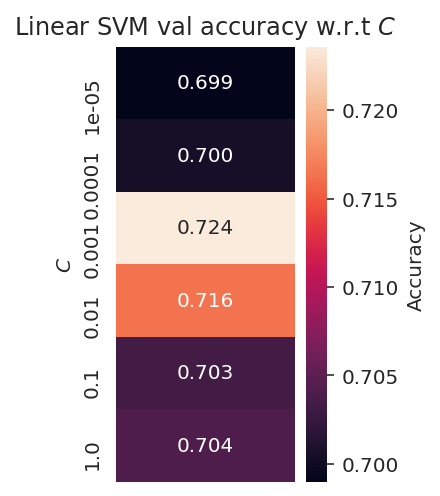

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

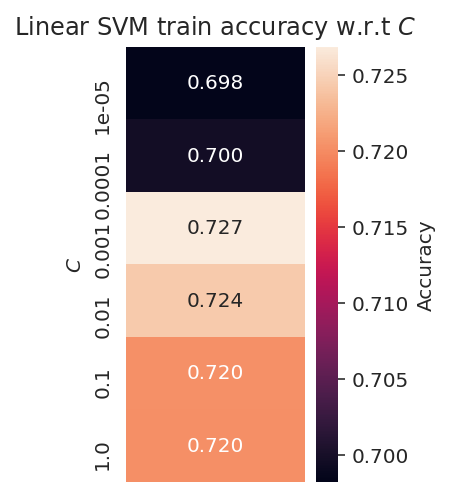

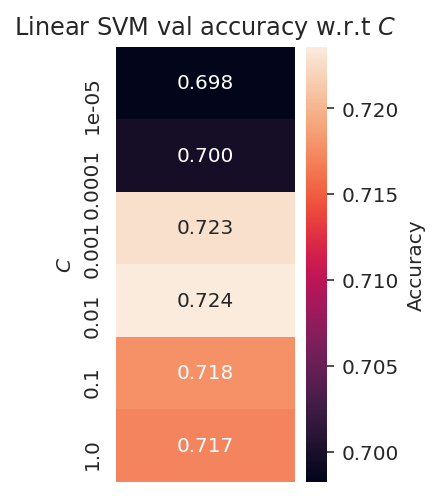

      Classifier  Best Parameter  Average Test Accuracy
0            KNN            5.00               0.939306
1  Decision Tree            5.00               0.935453
2     Linear SVM            0.01               0.717726


/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [32]:
# Splitting the DataFrame into features (X) and target (y)
X = df[:, :-1]  # Features (all columns except the last)
y = df[:, -1]   # Target (the last column)

# Store results
results = {
    'Classifier': ['KNN', 'Decision Tree', 'Linear SVM'],
    'Best Parameter': [],
    'Average Test Accuracy': []
}

# Run three trials for each classifier
for classifier in [knn, dt, svm_linear]:
    test_accuracies = []
    best_params = []
    for _ in range(3):
        # Split the dataset into training and testing sets
        X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

        # Train and evaluate the classifier
        best_param, test_acc = classifier(X_train_val, Y_train_val, X_test, Y_test)
        test_accuracies.append(test_acc)
        best_params.append(best_param)

    # Compute the average test accuracy
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    results['Average Test Accuracy'].append(avg_test_acc)

    # Determine the best parameter (most frequent)
    best_param = max(set(best_params), key=best_params.count)
    results['Best Parameter'].append(best_param)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

## Partition: 50/50 -> 3 Trials 

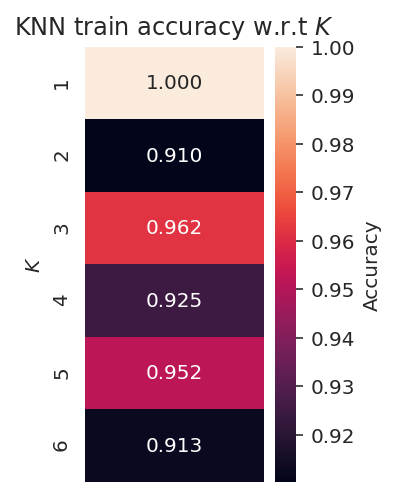

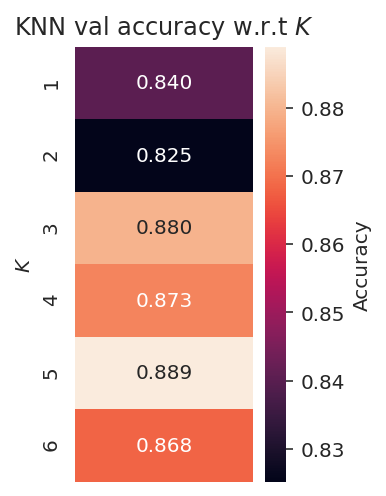

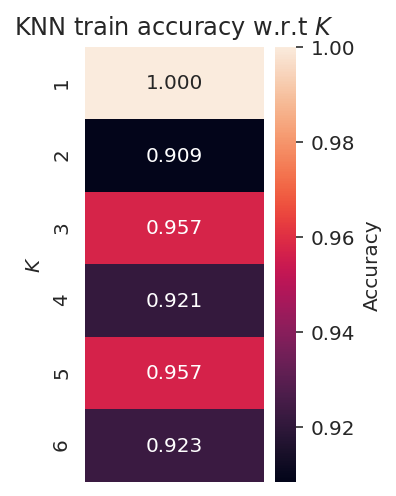

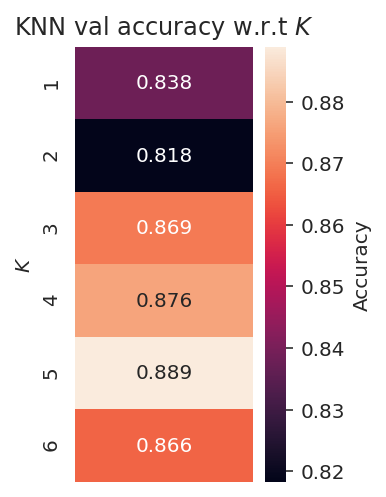

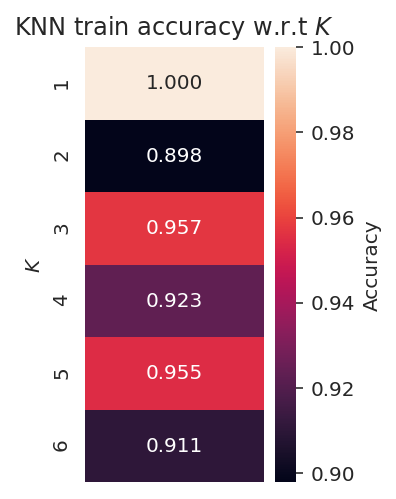

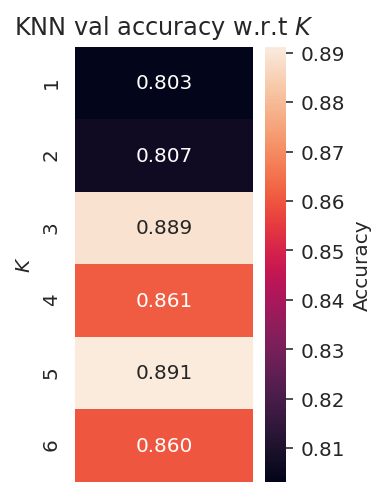

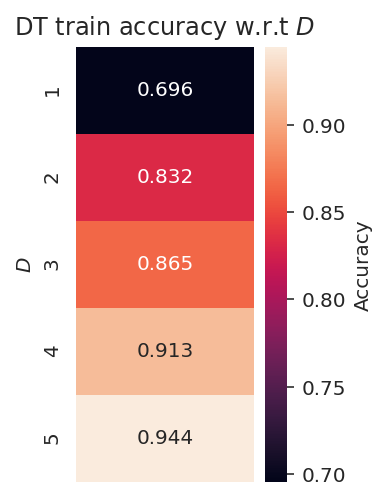

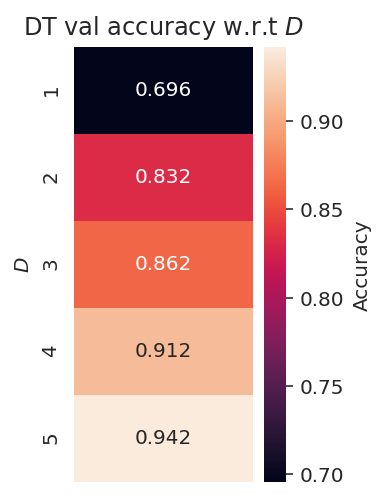

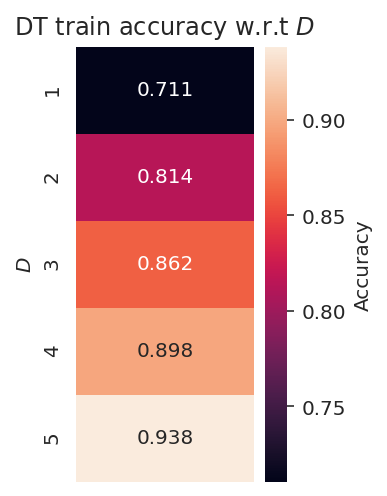

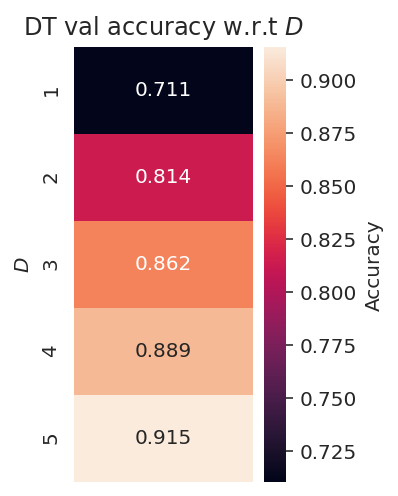

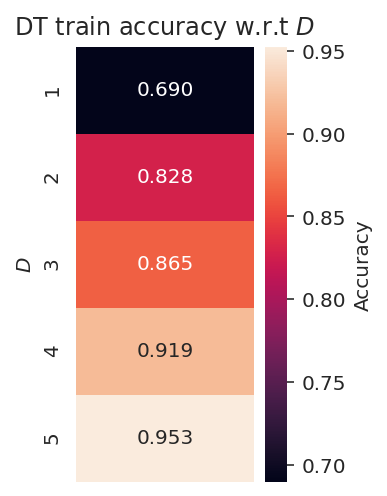

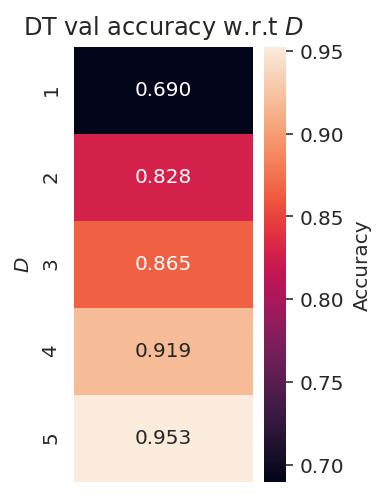

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

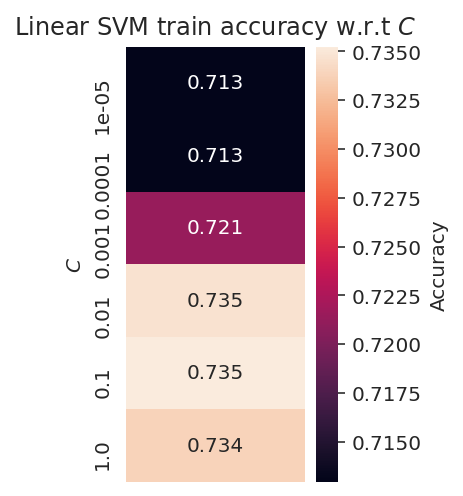

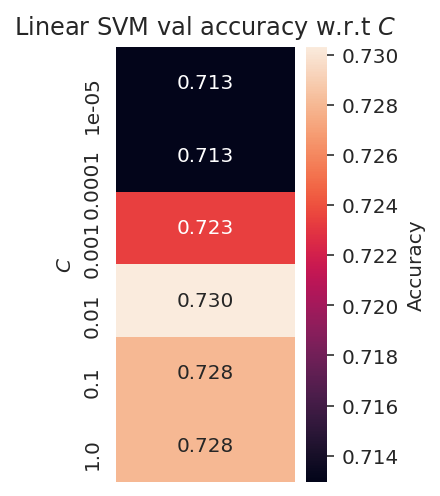

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

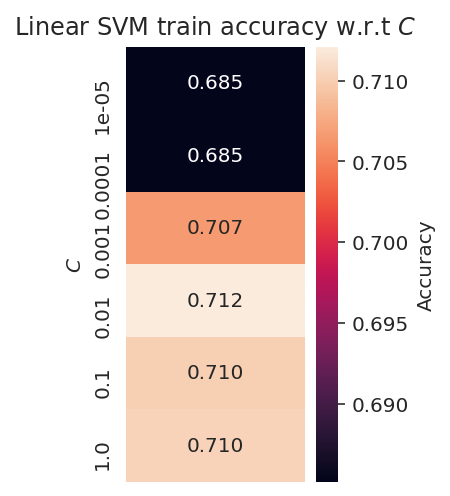

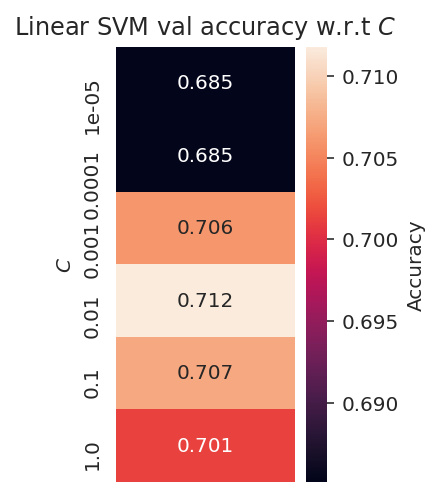

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

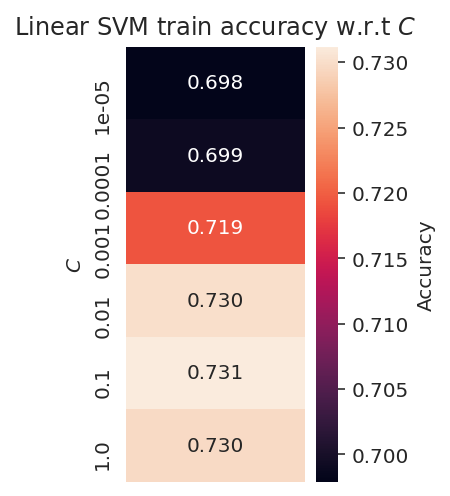

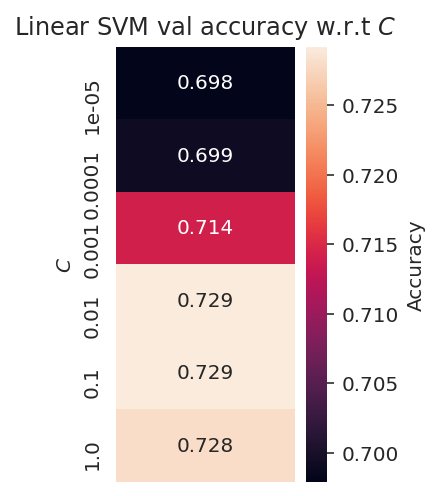

      Classifier  Best Parameter  Average Test Accuracy
0            KNN            5.00               0.920910
1  Decision Tree            5.00               0.922454
2     Linear SVM            0.01               0.728009


/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [33]:
# Splitting the DataFrame into features (X) and target (y)
X = df[:, :-1]  # Features (all columns except the last)
y = df[:, -1]   # Target (the last column)

# Store results
results = {
    'Classifier': ['KNN', 'Decision Tree', 'Linear SVM'],
    'Best Parameter': [],
    'Average Test Accuracy': []
}

# Run three trials for each classifier
for classifier in [knn, dt, svm_linear]:
    test_accuracies = []
    best_params = []
    for _ in range(3):
        # Split the dataset into training and testing sets
        X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.5,shuffle=True)

        # Train and evaluate the classifier
        best_param, test_acc = classifier(X_train_val, Y_train_val, X_test, Y_test)
        test_accuracies.append(test_acc)
        best_params.append(best_param)

    # Compute the average test accuracy
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    results['Average Test Accuracy'].append(avg_test_acc)

    # Determine the best parameter (most frequent)
    best_param = max(set(best_params), key=best_params.count)
    results['Best Parameter'].append(best_param)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

## Partition: 20/80 -> 3 Trials 

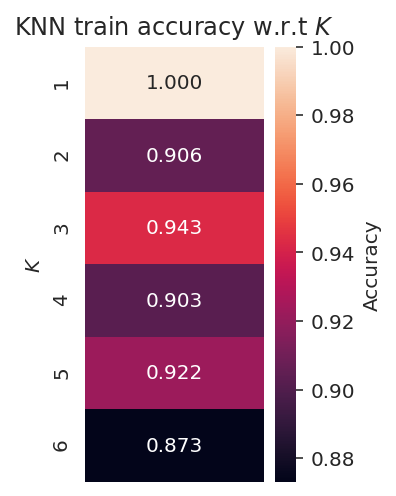

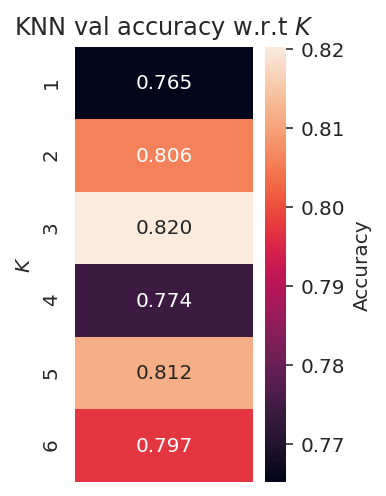

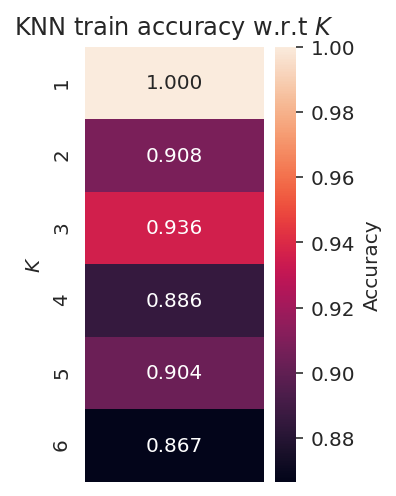

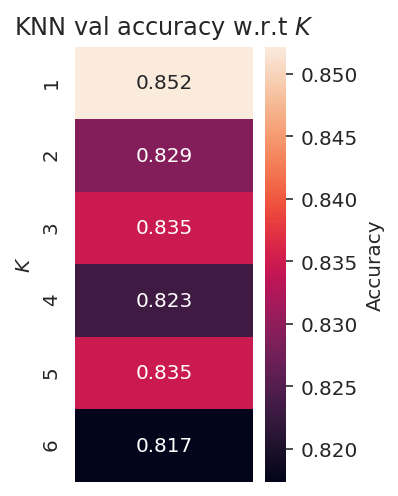

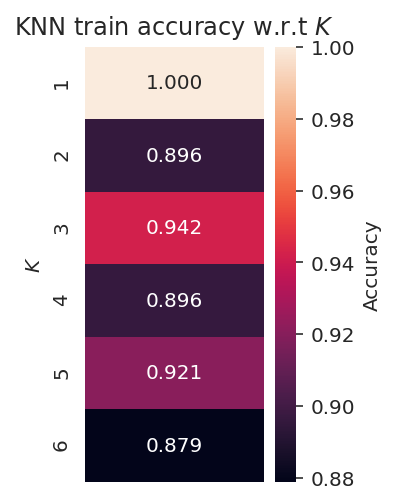

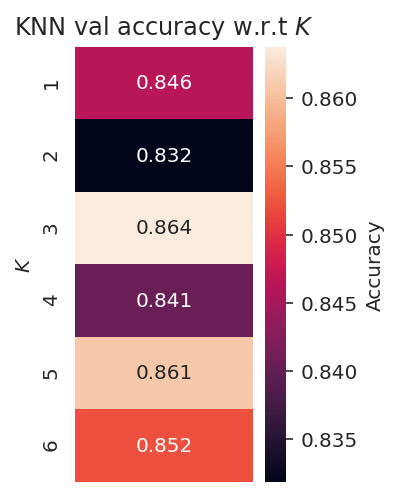

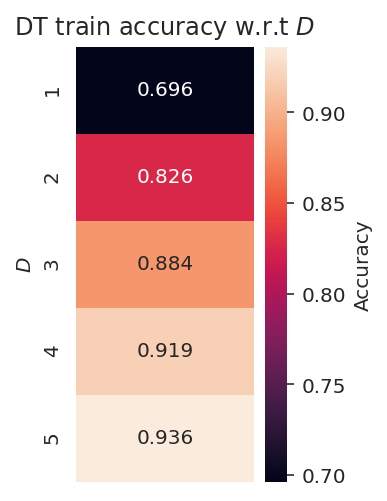

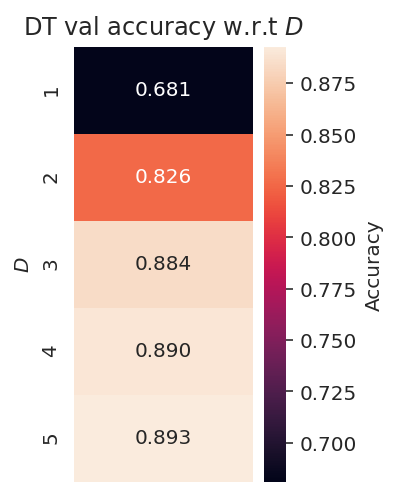

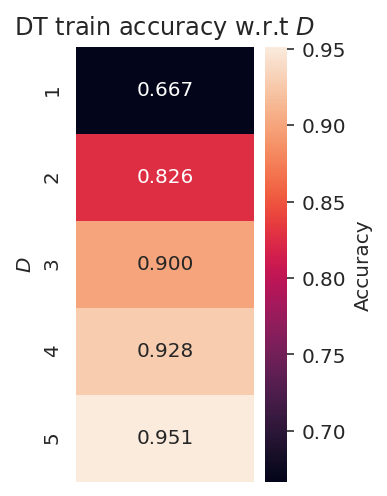

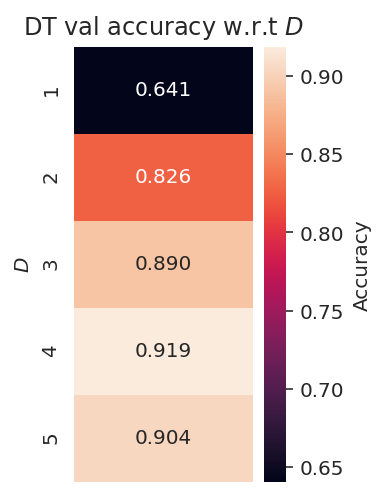

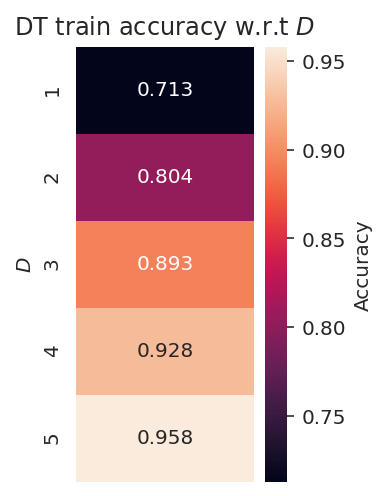

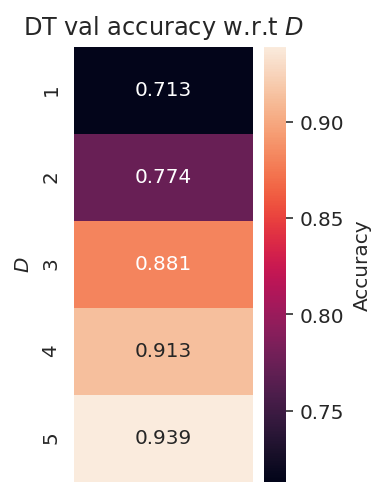

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

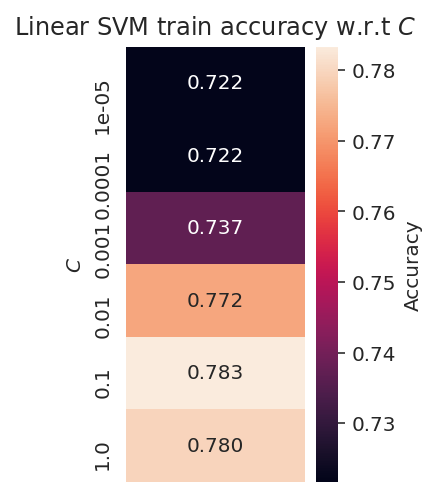

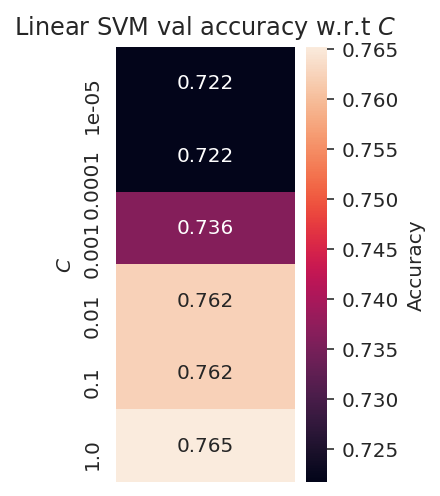

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

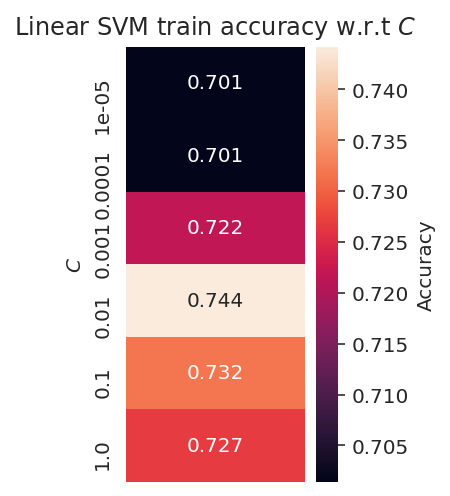

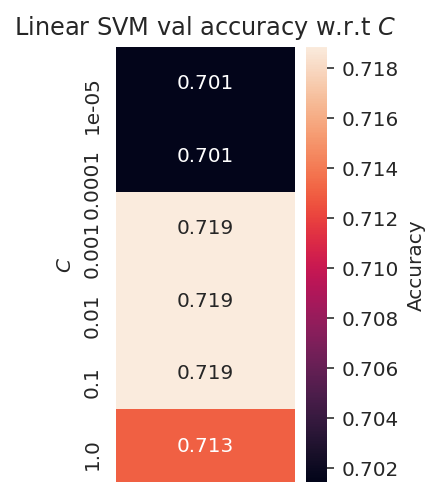

/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mabdilah/.local/lib/python

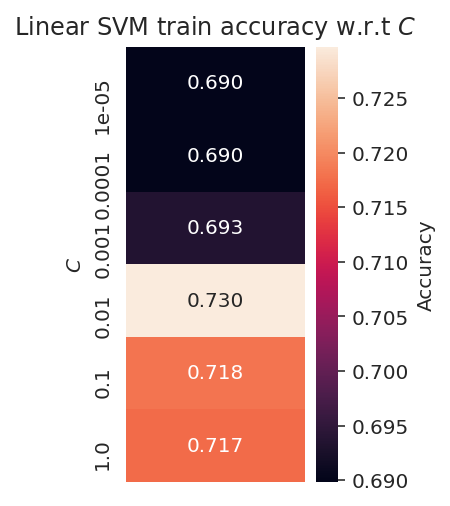

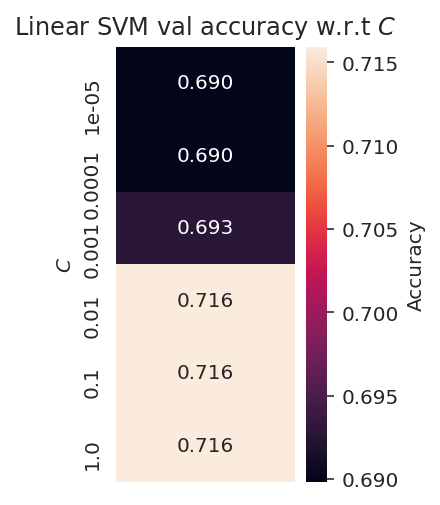

      Classifier  Best Parameter  Average Test Accuracy
0            KNN             3.0               0.827669
1  Decision Tree             5.0               0.903832
2     Linear SVM             1.0               0.722584


/home/mabdilah/.local/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [34]:
# Splitting the DataFrame into features (X) and target (y)
X = df[:, :-1]  # Features (all columns except the last)
y = df[:, -1]   # Target (the last column)

# Store results
results = {
    'Classifier': ['KNN', 'Decision Tree', 'Linear SVM'],
    'Best Parameter': [],
    'Average Test Accuracy': []
}

# Run three trials for each classifier
for classifier in [knn, dt, svm_linear]:
    test_accuracies = []
    best_params = []
    for _ in range(3):
        # Split the dataset into training and testing sets
        X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.8,shuffle=True)

        # Train and evaluate the classifier
        best_param, test_acc = classifier(X_train_val, Y_train_val, X_test, Y_test)
        test_accuracies.append(test_acc)
        best_params.append(best_param)

    # Compute the average test accuracy
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    results['Average Test Accuracy'].append(avg_test_acc)

    # Determine the best parameter (most frequent)
    best_param = max(set(best_params), key=best_params.count)
    results['Best Parameter'].append(best_param)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)